In [1]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Using TensorFlow backend.


In [2]:
import numpy as np

# Standardization
mean = np.mean(train_data, axis=0)
std_deviation = np.std(train_data, axis=0)

train_data = (train_data - mean) / std_deviation
test_data = (test_data - mean) / std_deviation

In [3]:
from keras import models, layers

# Becaus training sample data is small, use a shallow model to avoid overfitting.

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    # Mesure Mean Absolute Errors, MAE during training.
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [4]:
# K-fold cross-validation

k = 4
# validation samples
num_val_samples = len(train_data) // k
num_epochs= 100
all_scores = []

for n in range(k):
    print('Start %d-fold training' % n)
    # Slice samples for validation.
    (first, last) = (n*num_val_samples, (n+1)*num_val_samples)
    val_data = train_data[first:last]
    val_targets = train_targets[first:last]
    
    # Concatenate the remaining samples.
    partial_train_data = np.concatenate(
        [train_data[:first], train_data[last:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:first], train_targets[last:]],
        axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs,
              batch_size=1,
              verbose=0)
    print('End %d-fold training.' % n)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

0-fold
End 0-fold training.
1-fold
End 1-fold training.
2-fold
End 2-fold training.
3-fold
End 3-fold training.


In [5]:
print(all_scores)
print(np.mean(all_scores))

[2.0956787838794217, 2.2205937970982919, 2.8599684120404838, 2.40535704039111]
2.39539950835


In [6]:
# K-fold cross-validation

k = 4
# validation samples
num_val_samples = len(train_data) // k
num_epochs= 500
all_mae_histories = []

for n in range(k):
    print('Start %d-fold training' % n)
    # Slice samples for validation.
    (first, last) = (n*num_val_samples, (n+1)*num_val_samples)
    val_data = train_data[first:last]
    val_targets = train_targets[first:last]
    
    # Concatenate the remaining samples.
    partial_train_data = np.concatenate(
        [train_data[:first], train_data[last:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:first], train_targets[last:]],
        axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs,
                        batch_size=1,
                        verbose=0)
    print('End %d-fold training.' % n)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

Start 0-fold training
End 0-fold training.
Start 1-fold training
End 1-fold training.
Start 2-fold training
End 2-fold training.
Start 3-fold training
End 3-fold training.


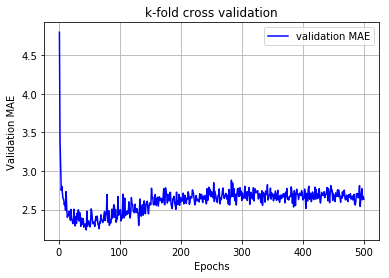

In [11]:
import matplotlib.pyplot as plt

average_mae_history = np.mean(all_mae_histories, axis=0)

epochs = np.arange(len(average_mae_history)) + 1

plt.figure('k-fold cross validation')
plt.title('k-fold cross validation')
plt.plot(epochs, average_mae_history, color='b', label='validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.legend()
plt.grid()
plt.show()

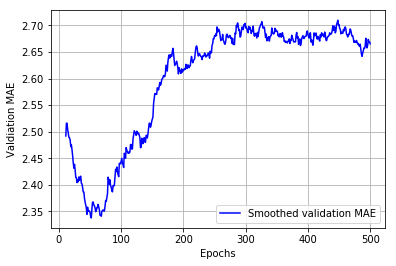

In [14]:
def smooth_curve(points, factor=0.9):
    '''
    Smooth the points by using exponential moving average, EMA.
    EMA makes time sequential data smooth.
    '''
    smoothed_points = []
    for p in points:
        if smoothed_points:
            prev = smoothed_points[-1]
            smoothed_points.append(prev*factor+p*(1-factor))
        else:
            smoothed_points.append(p)
    return smoothed_points

# Remove first 10 samples which make extreme changes.
# Smooth the points by using exponential moving average.
smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.figure('Smoothed k-fold cross validation')
plt.plot(epochs[10:], smooth_mae_history, color='b', label='Smoothed validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Valdiation MAE')
plt.legend()
plt.grid()
plt.show()

# This graph represent model is overfitting after epoch=80.

In [15]:
# Final model tuning and training.

model = build_model()
model.fit(train_data, train_targets,
          epochs=80,
          batch_size=16,
          verbose=0)

102/102 [==============================] - 0s 675us/step
2.67502691232


In [16]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

print('Test samples, MAE =', test_mae_score)

102/102 [==============================] - 0s 115us/step
Test samples, MAE = 2.67502691232
